In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gpu.gpu_model import GPU, V100_SXM2, A100, H100_SXM5

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
alpha = np.linspace(-0.2, 0.2, 1001)

#ref_training_flop = 3.675e24 # T_0
ref_training_flop = 3e23
ref_batch_toks = 4e6 # b_0
ref_num_layers = 100 # L_0

ref_factor = ref_batch_toks/ref_num_layers * ref_training_flop**-alpha

training_duration_secs = 365.25 * 86400 / 4 # 3 months

gpus = [V100_SXM2, A100, H100_SXM5]

V100 SXM scales from 1.30e+27 to 2.19e+29 (167.9x)
A100 SXM scales from 2.62e+28 to 3.25e+31 (1240.6x)
H100 SXM scales from 1.92e+28 to 1.94e+31 (1009.4x)


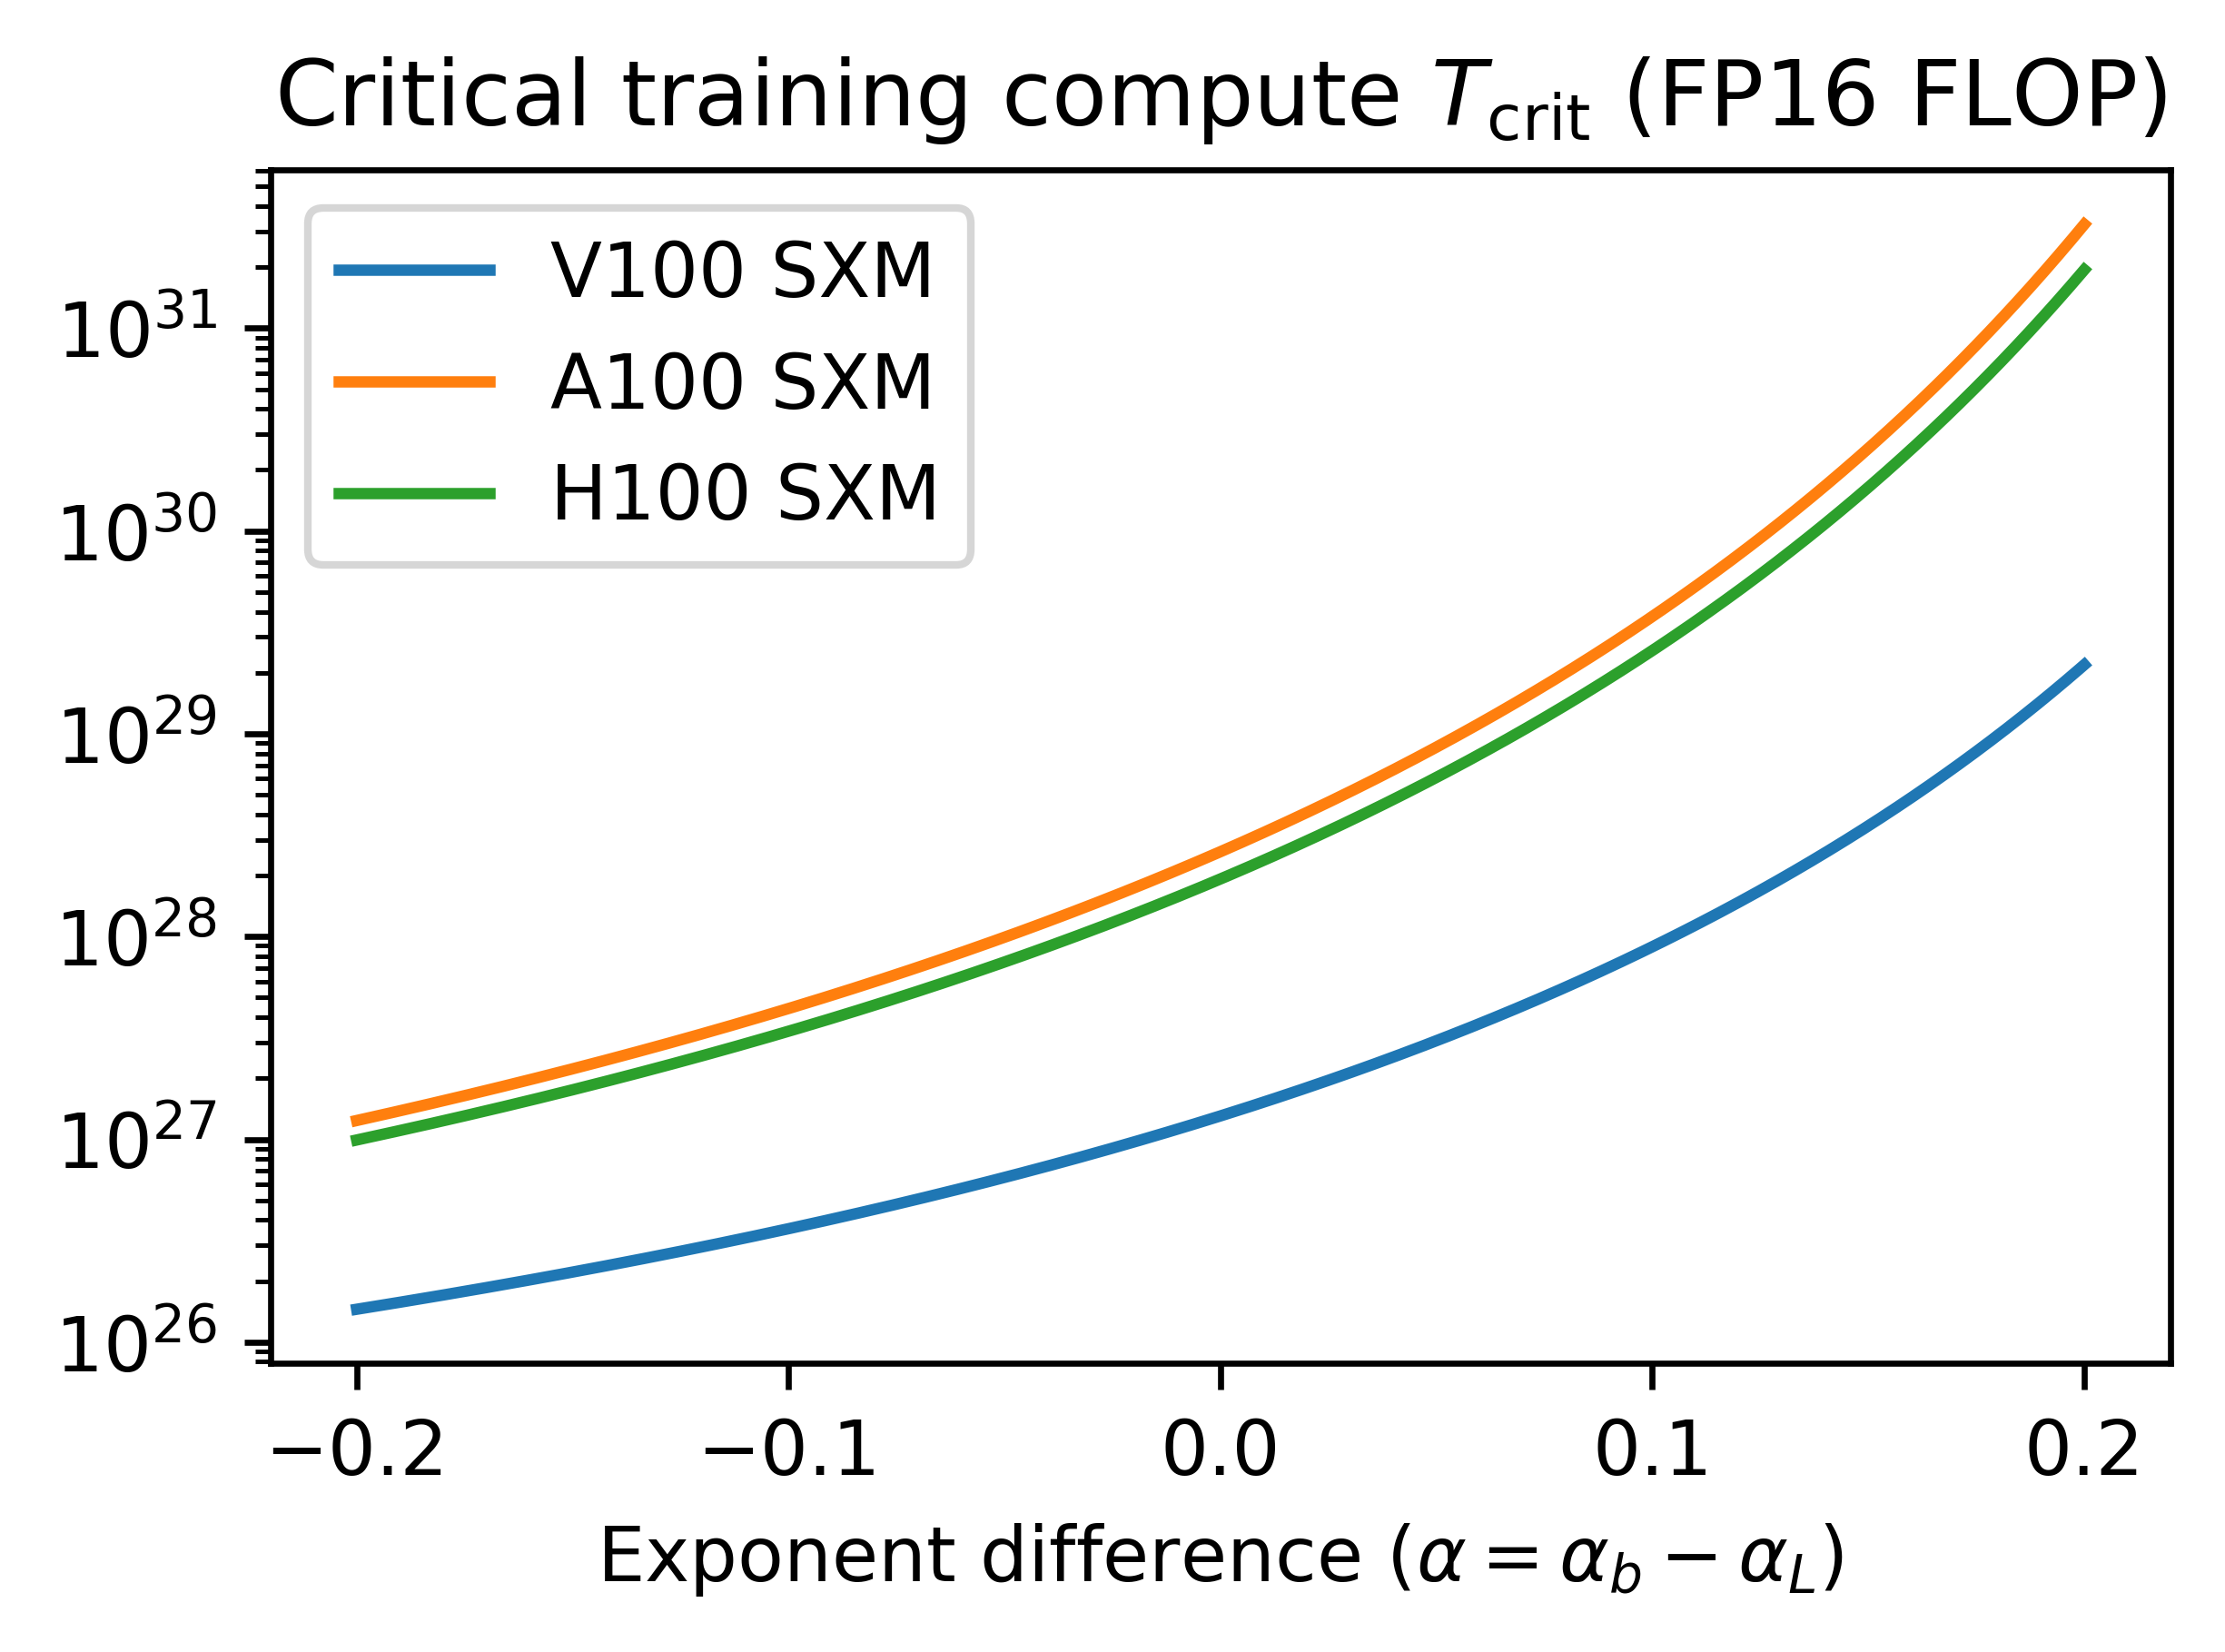

In [3]:
plt.figure(dpi=600, figsize=(4.5, 3))
for gpu in gpus:
    node_size = gpu.level_sizes[0]
    mac_per_sec = node_size*gpu.max_flop_per_s/2
    net_unidir_words_per_sec = node_size*gpu.network_bandwidths_per_level_Bps[1]/(2*gpu.bytewidth)
    mem_unidir_words_per_sec = node_size*gpu.global_Bps/(2*gpu.bytewidth)
    nanobatch_size = mac_per_sec / mem_unidir_words_per_sec
    activation_shard_size = (4 * mac_per_sec) / (3 * net_unidir_words_per_sec)

    # print(f'MAC/s: {mac_per_sec:.2e}, Net words/s: {net_unidir_words_per_sec:.2e}, Mem words/s: {mem_unidir_words_per_sec:.2e}')
    # print(f'Nanobatch size: {int(nanobatch_size)}, Activation shard size: {int(activation_shard_size)}')
    # print(f'Critical compute for alpha=0: {flop_crit[alpha == 0][0]:.2e}')
    mac_crit = (1/960 * (ref_factor *
                        (mac_per_sec * training_duration_secs)/(activation_shard_size**2 * nanobatch_size))**2)**(1/(1-2*alpha))
    flop_crit = 2*mac_crit
    print(f'{gpu.name} scales from {flop_crit[alpha == 0][0]:.2e} to {flop_crit[alpha >= 0.2][0]:.2e} ({(flop_crit[alpha == 0.2]/flop_crit[alpha == 0])[0]:.1f}x)')
    plt.plot(alpha, flop_crit, label=gpu.name)
assert all(gpus[0].bitwidth == gpu.bitwidth for gpu in gpus)
plt.title('Critical training compute $T_\\text{crit}$ '+f'(FP{gpus[0].bitwidth} FLOP)')
plt.xlabel('Exponent difference ($\\alpha = \\alpha_b - \\alpha_L$)')
plt.gcf().subplots_adjust(bottom=0.15)
plt.yscale('log')
plt.legend()
plt.savefig("visuals/sensitivity_tcrit.png")
plt.savefig("visuals/sensitivity_tcrit.pdf")
plt.show()


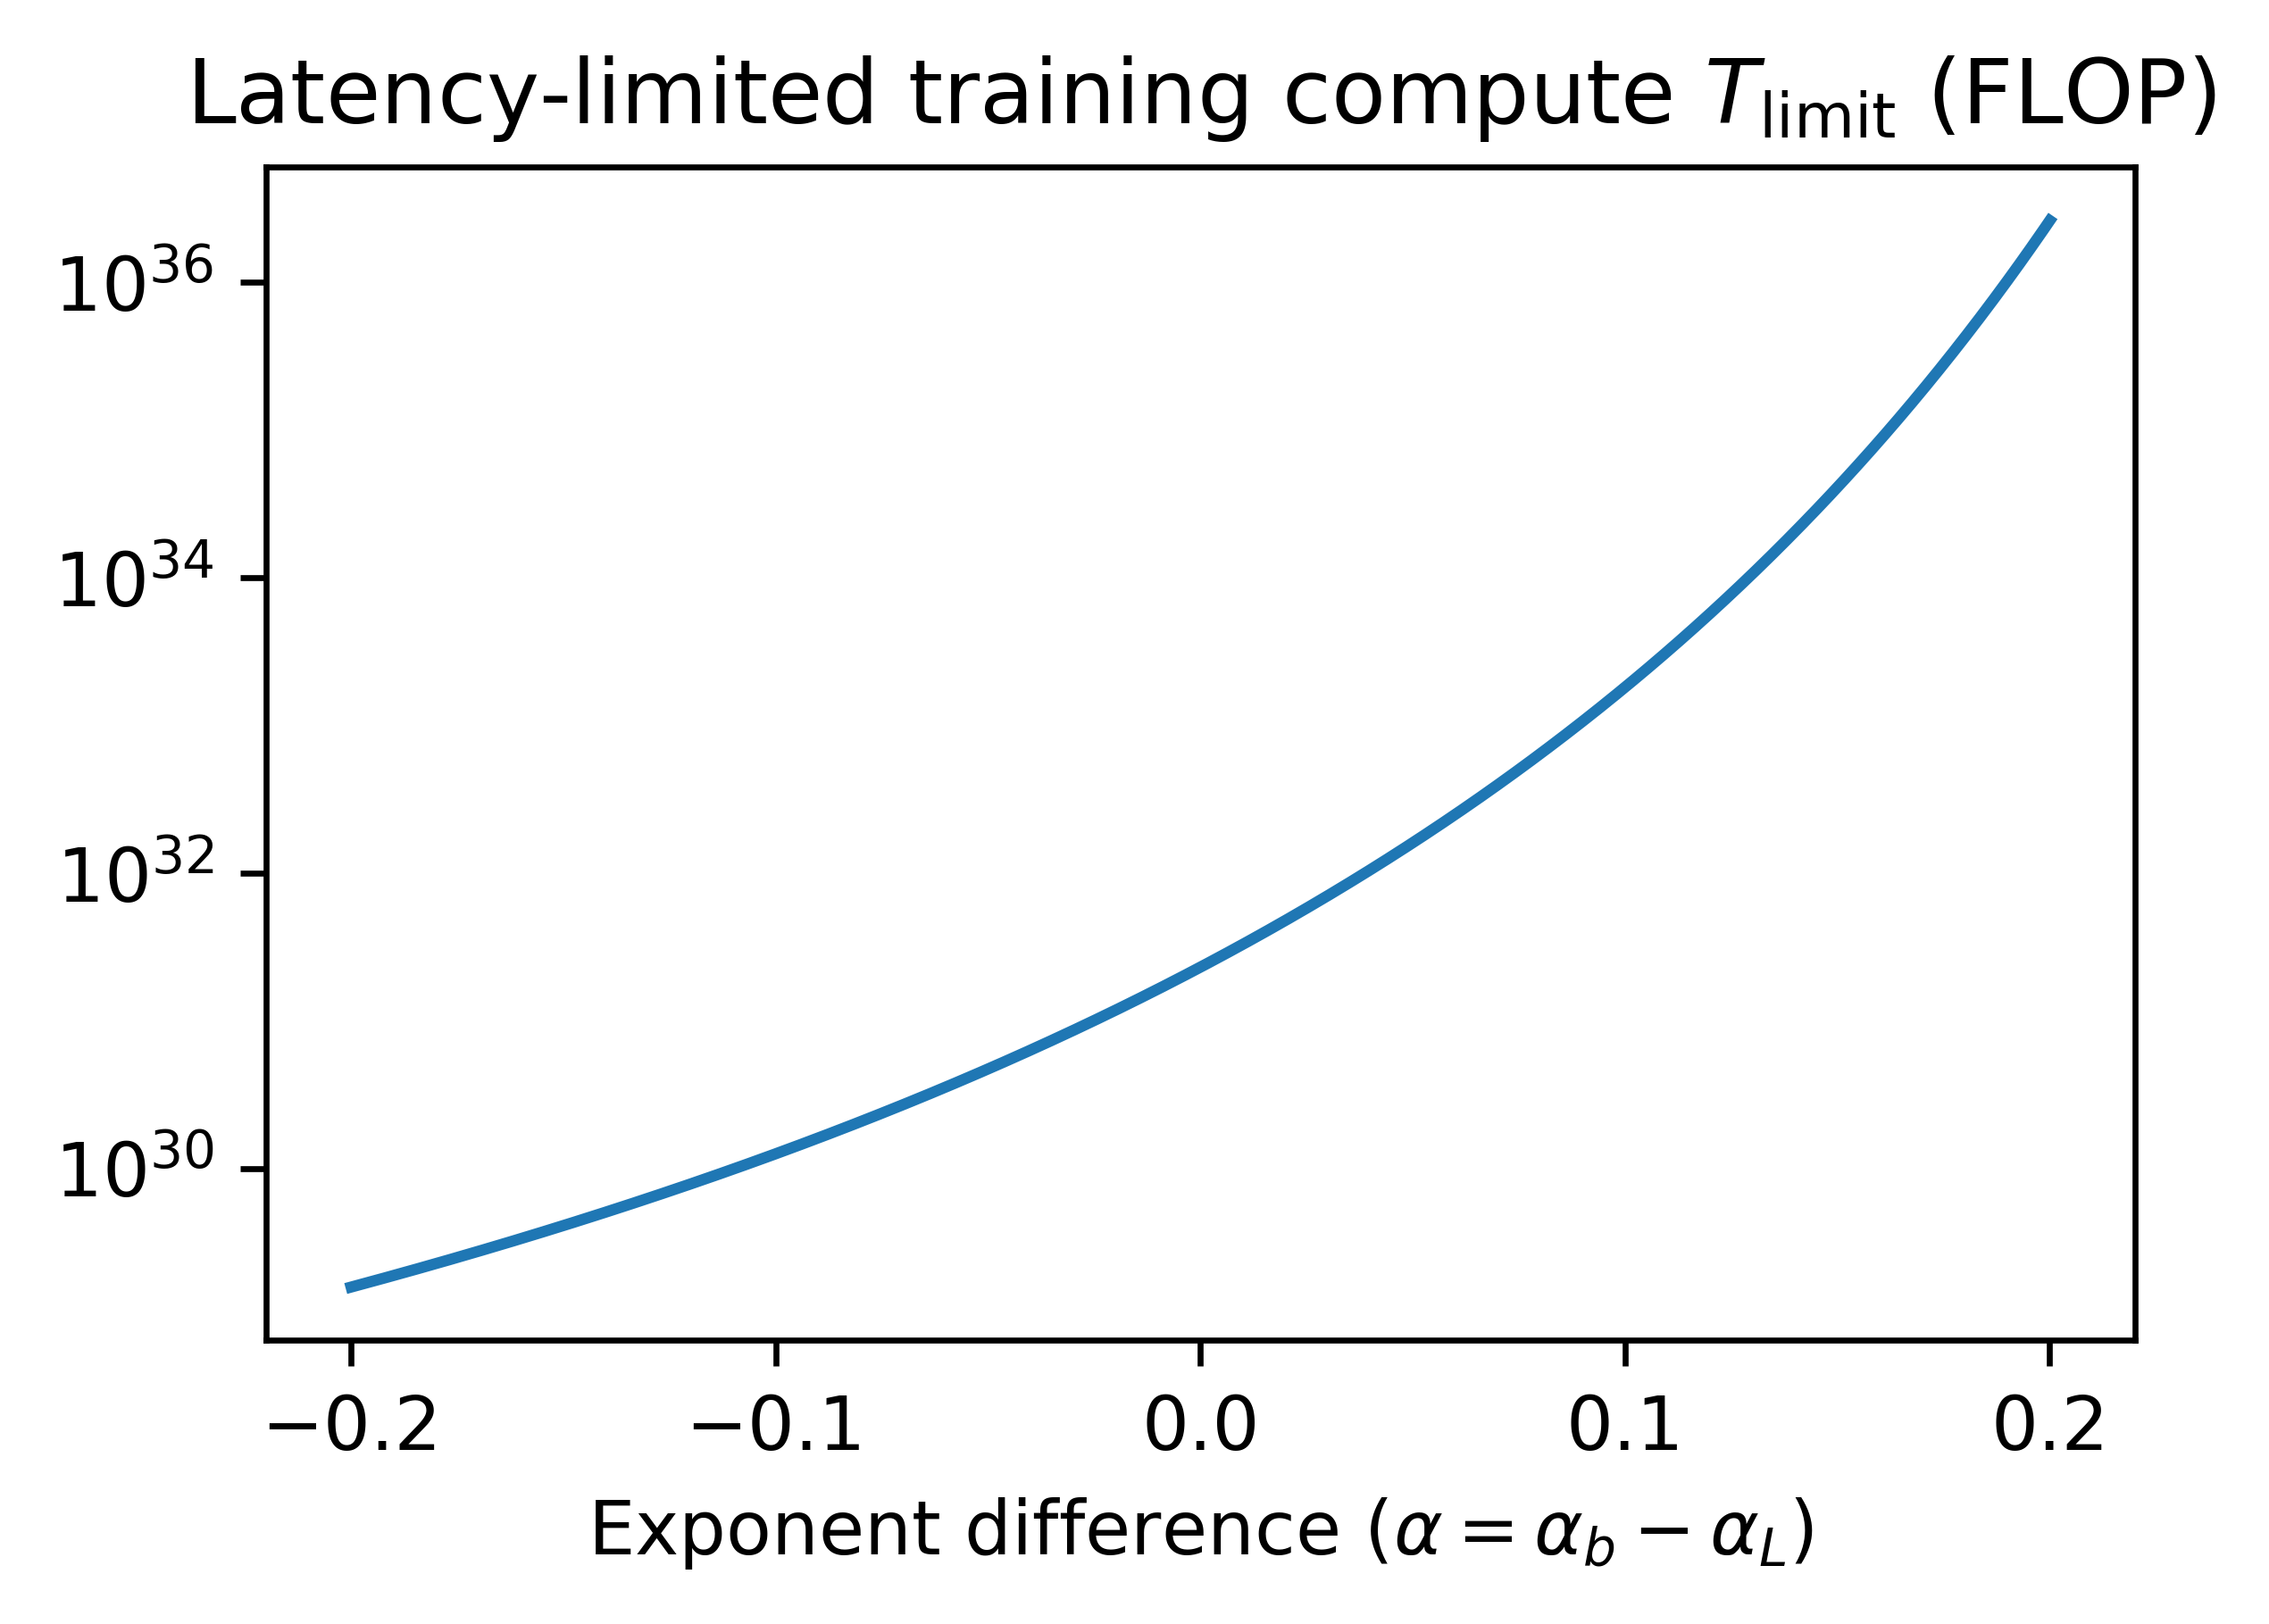

In [4]:
latency_scale_secs = 9e-6

plt.figure(dpi=600, figsize=(4.5, 3))
mac_lim = (3/320 * (ref_factor * training_duration_secs/latency_scale_secs)**2)**(1/(1-2*alpha))
flop_lim = 2*mac_lim
plt.plot(alpha, flop_lim)
plt.title('Latency-limited training compute $T_\\text{limit}$ (FLOP)')
plt.xlabel('Exponent difference ($\\alpha = \\alpha_b - \\alpha_L$)')
plt.gcf().subplots_adjust(bottom=0.15)
plt.yscale('log')
plt.savefig("visuals/sensitivity_tlimit.png")
plt.savefig("visuals/sensitivity_tlimit.pdf")
plt.show()
